In [77]:
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_columns', 50)

## Load Data

In [78]:
data_dir = '/Users/jujohnson/tmdb-5000-data/'
credits_path = os.path.join(data_dir, 'tmdb_5000_credits.csv')
movies_path = os.path.join(data_dir, 'tmdb_5000_movies.csv')

In [79]:
credits = pd.read_csv(credits_path)
movies = pd.read_csv(movies_path)

## Merge DataFrames

In [80]:
credits.rename(columns={ 'movie_id': 'id' }, inplace=True)

In [81]:
movie_df = pd.merge(credits, movies, on='id')

In [82]:
print(f'Merged movie data shape {movie_df.shape}')
movie_df.head(2)

Merged movie data shape (4803, 23)


,id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


## Remove Non-required Columns

In [83]:
movie_df = movie_df[['id', 'title_x', 'revenue', 'vote_average', 'vote_count', 'popularity']]

## Compute Weighted Vote Average

$$W = \frac{Rv + Cm}{v + m}$$



W = weighted rating

R = average vote for movie (0 - 10)

v = number of votes for movie

m = minimum votes required to be included

C = mean vote across whole report


In [84]:
R, v = movie_df.loc[:, ['vote_average']].values, movie_df.loc[:, ['vote_count']].values
C = movie_df.vote_average.mean()
m = movie_df.vote_count.quantile(.7)
print(f'C: {C}, m: {m}')

C: 6.092171559442016, m: 581.0


In [86]:
movie_df.loc[:, ('weighted_average')] = ((R * v) + (C * m)) / (v + m)

In [87]:
print('Viewing top 10 recommenations using weighted average of user vote')

top_ten_recs = movie_df.sort_values(by='weighted_average', ascending=False) \
    .set_index('id').head(10)

top_ten_recs

Viewing top 10 recommenations using weighted average of user vote


,title_x,revenue,vote_average,vote_count,popularity,weighted_average
id,,,,,,
278,The Shawshank Redemption,28341469,8.5,8205,136.747729,8.340775
238,The Godfather,245066411,8.4,5893,143.659698,8.192887
550,Fight Club,100853753,8.3,9413,146.757391,8.171648
680,Pulp Fiction,213928762,8.3,8428,121.463076,8.157615
155,The Dark Knight,1004558444,8.2,12002,187.322927,8.102674
13,Forrest Gump,677945399,8.2,7927,138.133331,8.056059
424,Schindler's List,321365567,8.3,4329,104.469351,8.038748
244786,Whiplash,13092000,8.3,4254,192.528841,8.034695
27205,Inception,825532764,8.1,13752,167.583710,8.018611


Text(0, 0.5, 'Movie Title')

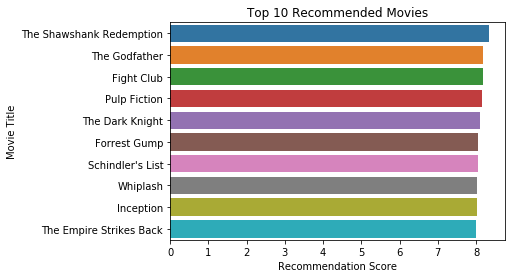

In [88]:
sns.barplot(data=top_ten_recs, x='weighted_average', y='title_x')
plt.title('Top 10 Recommended Movies');
plt.xlabel('Recommendation Score');
plt.ylabel('Movie Title')

## Let's Incorporate Popularity Scores

Recommendation score will be 50% weighted average score and 50% popularity score.

Since these attributes are on different scales, we must normalize them before combining.

In [109]:
# these values are on different scales, so we must normalize them before combining
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

to_scale = movie_df.loc[:, ['weighted_average', 'popularity']]

normalized = pd.DataFrame( \
    scaler.fit_transform(to_scale),
    columns=['weighted_average_norm', 'popularity_norm'])

movie_df[['weighted_average_norm', 'popularity_norm']] = normalized

In [111]:
movie_df['score'] = movie_df['weighted_average_norm'] * 0.5 + movie_df['popularity_norm'] * 0.5

In [114]:
top_ten_scores = movie_df.sort_values(by='score', ascending=False).head(10)

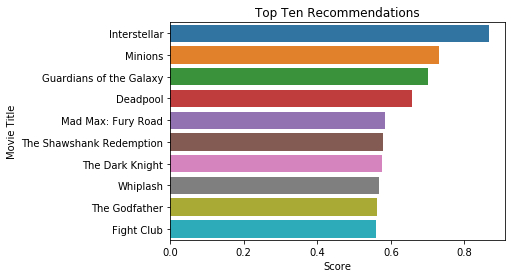

In [115]:
sns.barplot(data=top_ten_scores, x='score', y='title_x');
plt.title('Top Ten Recommendations');
plt.ylabel('Movie Title');
plt.xlabel('Score');